In [ ]:
# Needed for successful imports
%cd ../..

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from src.Dataset import CustomDataset
from src.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from src.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

# set seed for pytorch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360

x_train = np.load(f'input/train_data_{dataset_ver}.npy')
x_val = np.load(f'input/val_data_{dataset_ver}.npy')
x_test = np.load(f'input/test_data_{dataset_ver}.npy')

y_train = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test = np.load(f'input/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(x_val.shape)

(11578, 60, 9)
(1654, 60, 9)


(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


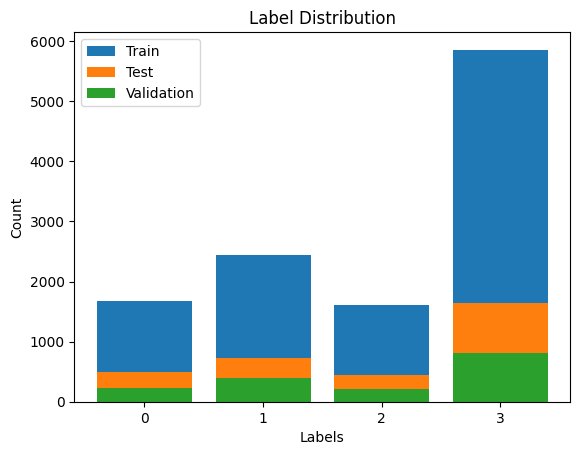

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

# Streamlined Train + Test Process

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard
# %reload_ext tensorboard
!taskkill /F /IM tensorboard.exe

ERROR: The process "tensorboard.exe" not found.


In [6]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

def streamline_train_and_test(Autoencoder, tag, early_stop, dropout_rate, num_epochs, lr_rate):
    ### Streamlined training of model + SVM ###
    encoder_ver = f'{n_hidden}h{num_epochs}e{dropout_rate}dr{lr_rate}lr'
    train_losses, val_losses = train_model(Autoencoder, train_dataloader, val_dataloader, val_dataset, n_input, n_hidden, dataset_ver, encoder_ver, tag, early_stop, dropout_rate, num_epochs, lr_rate)
    plot_loss_graph(train_losses, val_losses, tag)
    encoded_data, labels = encode_data(train_dataloader, dataset_ver, tag, encoder_ver)
    svm_classifier = train_svm(encoded_data, labels.ravel(), dataset_ver, tag, encoder_ver)
    ### Streamlined testing of model + SVM ###
    test_labels, test_predictions = test_model(test_dataloader, dataset_ver, tag, encoder_ver)
    calculate_accuracy(test_labels, test_predictions, tag)

# LSTM Models

In [7]:
# Unidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        encoded_x = self.dropout(encoded_x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0337, Val Loss: 0.0384
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0436, Val Loss: 0.0369
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0254, Val Loss: 0.0263
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0156, Val Loss: 0.0155
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0138, Val Loss: 0.0124
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0104, Val Loss: 0.0108
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0102, Val Loss: 0.0096
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0058, Val Loss: 0.0088
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0091, Val Loss: 0.0083
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0075, Val Loss: 0.0076
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0091, Val Loss: 0.0073
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0075, Val Loss: 0.0069
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0073, Val Loss: 0.0071
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0063, Val Loss: 0.0069
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0053, Val Loss: 0.0064
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0049, Val Loss: 0.0060
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0045, Val Loss: 0.0057
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0052, Val Loss: 0.0056
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0039, Val Loss: 0.0055
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0062, Val Loss: 0.0056
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0051, Val Loss: 0.0053
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0040, Val Loss: 0.0051
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0049, Val Loss: 0.0059
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0057, Val Loss: 0.0050
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0046, Val Loss: 0.0054
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0053, Val Loss: 0.0047
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0046, Val Loss: 0.0047
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0033, Val Loss: 0.0048
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0042, Val Loss: 0.0049
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0028, Val Loss: 0.0046
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0037, Val Loss: 0.0045
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0049, Val Loss: 0.0044
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0056, Val Loss: 0.0045
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0030, Val Loss: 0.0041
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0048, Val Loss: 0.0041
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0027, Val Loss: 0.0042
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0039, Val Loss: 0.0039
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0029, Val Loss: 0.0037
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0046, Val Loss: 0.0039
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0033, Val Loss: 0.0040
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0043, Val Loss: 0.0037
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0037, Val Loss: 0.0039
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0032, Val Loss: 0.0038
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0024, Val Loss: 0.0038
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0029, Val Loss: 0.0036
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0036, Val Loss: 0.0035
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0034, Val Loss: 0.0035
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0038, Val Loss: 0.0036
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0032, Val Loss: 0.0035
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0037, Val Loss: 0.0035


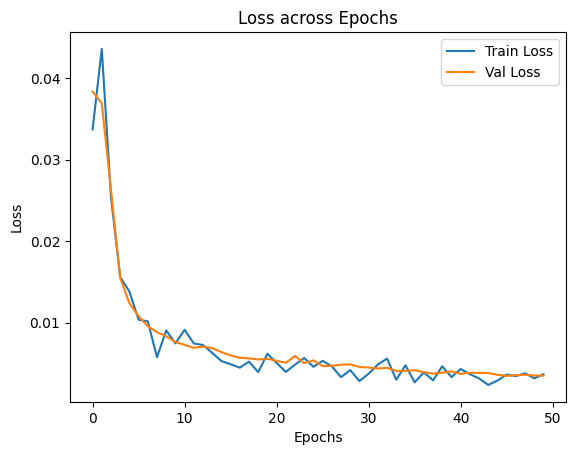

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9494818652849741


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.71%


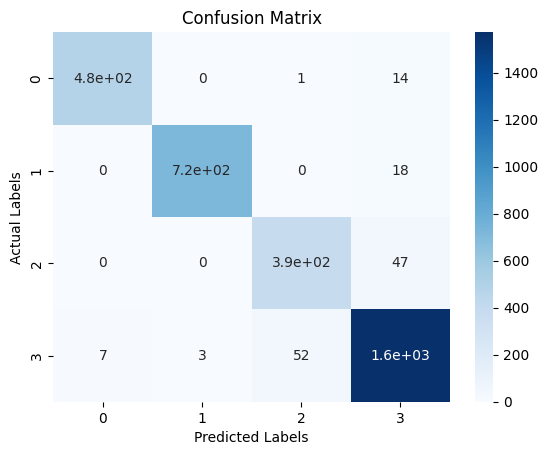

In [8]:
streamline_train_and_test(Autoencoder, tag="lstm_run_1_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

In [9]:
# Unidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size*2, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        return encoded_x[-1,:,:]


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size*2, batch_first=True)
        self.output = nn.Linear(self.hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 720, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(360, 720, batch_first=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0467, Val Loss: 0.0438
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0328, Val Loss: 0.0396
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0200, Val Loss: 0.0251
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0156, Val Loss: 0.0152
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0083, Val Loss: 0.0124
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0130, Val Loss: 0.0109
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0097, Val Loss: 0.0105
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0121, Val Loss: 0.0097
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0070, Val Loss: 0.0089
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0053, Val Loss: 0.0077
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0071, Val Loss: 0.0072
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0073, Val Loss: 0.0073
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0068, Val Loss: 0.0065
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0048, Val Loss: 0.0063
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0076, Val Loss: 0.0065
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0052, Val Loss: 0.0061
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0056, Val Loss: 0.0057
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0071, Val Loss: 0.0052
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0060, Val Loss: 0.0055
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0034, Val Loss: 0.0051
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0053, Val Loss: 0.0049
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0050, Val Loss: 0.0049
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0058, Val Loss: 0.0045
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0035, Val Loss: 0.0051
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0037, Val Loss: 0.0050
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0043, Val Loss: 0.0045
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0054, Val Loss: 0.0045
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0037, Val Loss: 0.0041
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0039, Val Loss: 0.0042
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0028, Val Loss: 0.0042
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0038, Val Loss: 0.0046
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0030, Val Loss: 0.0041
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0032, Val Loss: 0.0039
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0028, Val Loss: 0.0040
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0031, Val Loss: 0.0039
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0039, Val Loss: 0.0038
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0032, Val Loss: 0.0040
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0040, Val Loss: 0.0037
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0038, Val Loss: 0.0040
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0035, Val Loss: 0.0037
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0026, Val Loss: 0.0038
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0038, Val Loss: 0.0036
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0032, Val Loss: 0.0035
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0043, Val Loss: 0.0036
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0033, Val Loss: 0.0035
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0019, Val Loss: 0.0033
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0027, Val Loss: 0.0036
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0030, Val Loss: 0.0033
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0023, Val Loss: 0.0033
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0021, Val Loss: 0.0034


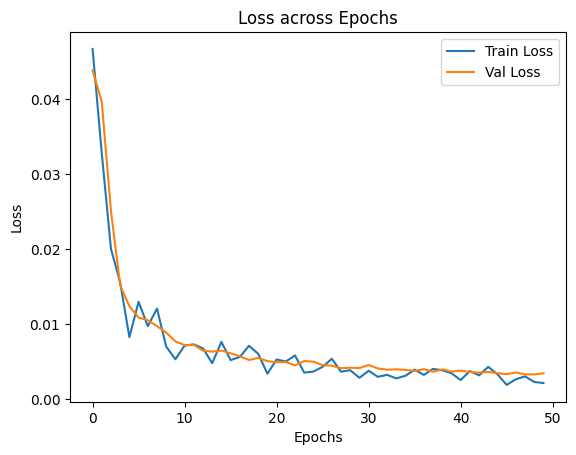

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9494818652849741


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.25%


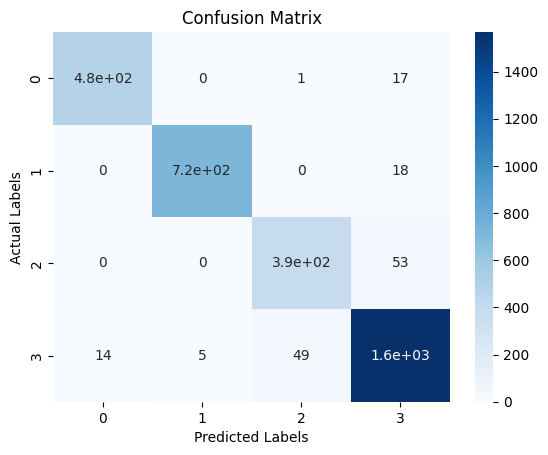

In [10]:
streamline_train_and_test(Autoencoder, tag="lstm_run_3_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

In [11]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0473, Val Loss: 0.0395
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0215, Val Loss: 0.0201
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0144, Val Loss: 0.0145
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0099, Val Loss: 0.0131
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0075, Val Loss: 0.0112
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0097, Val Loss: 0.0096
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0110, Val Loss: 0.0091
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0058, Val Loss: 0.0086
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0065, Val Loss: 0.0078
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0094, Val Loss: 0.0076
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0082, Val Loss: 0.0071
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0117, Val Loss: 0.0076
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0053, Val Loss: 0.0063
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0073, Val Loss: 0.0067
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0045, Val Loss: 0.0058
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0054, Val Loss: 0.0054
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0074, Val Loss: 0.0056
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0051, Val Loss: 0.0052
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0040, Val Loss: 0.0051
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0037, Val Loss: 0.0051
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0043, Val Loss: 0.0050
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0041, Val Loss: 0.0048
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0045, Val Loss: 0.0048
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0039, Val Loss: 0.0045
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0062, Val Loss: 0.0043
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0032, Val Loss: 0.0042
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0048, Val Loss: 0.0043
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0034, Val Loss: 0.0042
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0054, Val Loss: 0.0043
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0039, Val Loss: 0.0041
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0031, Val Loss: 0.0039
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0040, Val Loss: 0.0039
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0026, Val Loss: 0.0040
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0048, Val Loss: 0.0038
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0034, Val Loss: 0.0039
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0031, Val Loss: 0.0035
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0039, Val Loss: 0.0037
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0029, Val Loss: 0.0035
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0031, Val Loss: 0.0038
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0061, Val Loss: 0.0034
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0026, Val Loss: 0.0034
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0033, Val Loss: 0.0032
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0033, Val Loss: 0.0032
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0023, Val Loss: 0.0033
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0024, Val Loss: 0.0033
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0041, Val Loss: 0.0032
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0023, Val Loss: 0.0031
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0028, Val Loss: 0.0031
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0022, Val Loss: 0.0031
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0043, Val Loss: 0.0032


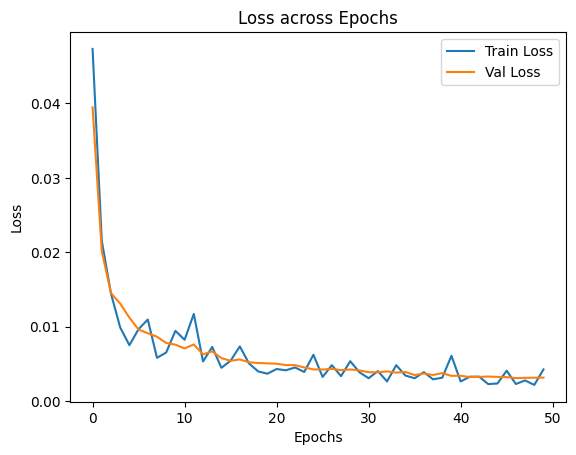

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9542314335060449


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.53%


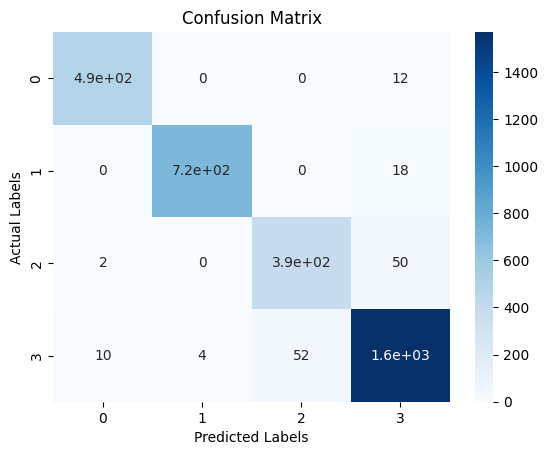

In [12]:
streamline_train_and_test(Autoencoder, tag="lstm_run_2_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0360, Val Loss: 0.0389
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0269, Val Loss: 0.0218
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0159, Val Loss: 0.0165
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0156, Val Loss: 0.0147
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0105, Val Loss: 0.0119
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0135, Val Loss: 0.0110
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0108, Val Loss: 0.0112
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0094, Val Loss: 0.0096
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0096, Val Loss: 0.0091
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0099, Val Loss: 0.0089
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0112, Val Loss: 0.0081
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0086, Val Loss: 0.0090
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0076, Val Loss: 0.0084
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0081, Val Loss: 0.0081
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0061, Val Loss: 0.0069
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0091, Val Loss: 0.0072
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0071, Val Loss: 0.0069
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0054, Val Loss: 0.0065
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0063, Val Loss: 0.0063
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0102, Val Loss: 0.0066
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0049, Val Loss: 0.0058
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0071, Val Loss: 0.0059
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0045, Val Loss: 0.0066
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0075, Val Loss: 0.0063
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0054, Val Loss: 0.0058
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0085, Val Loss: 0.0054
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0067, Val Loss: 0.0055
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0054, Val Loss: 0.0052
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0061, Val Loss: 0.0053
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0059, Val Loss: 0.0052
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0078, Val Loss: 0.0052
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0057, Val Loss: 0.0052
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0052, Val Loss: 0.0053
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0042, Val Loss: 0.0051
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0070, Val Loss: 0.0051
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0038, Val Loss: 0.0052
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0041, Val Loss: 0.0050
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0047, Val Loss: 0.0048
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0057, Val Loss: 0.0048
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0056, Val Loss: 0.0046
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0060, Val Loss: 0.0045
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0061, Val Loss: 0.0047
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0052, Val Loss: 0.0046
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0068, Val Loss: 0.0046
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0053, Val Loss: 0.0048
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0047, Val Loss: 0.0044
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0055, Val Loss: 0.0045
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0049, Val Loss: 0.0047
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0049, Val Loss: 0.0044
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0031, Val Loss: 0.0044


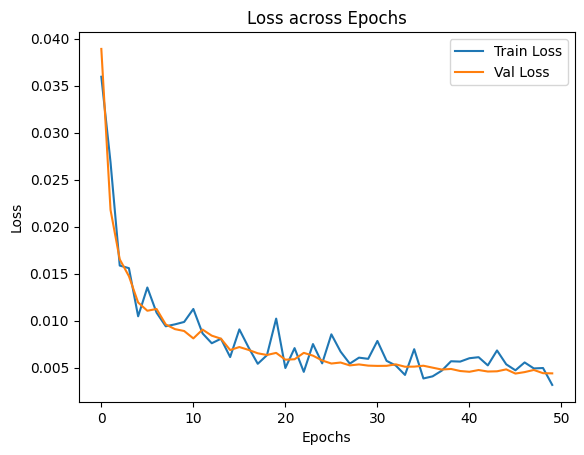

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9641623488773747


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 97.07%


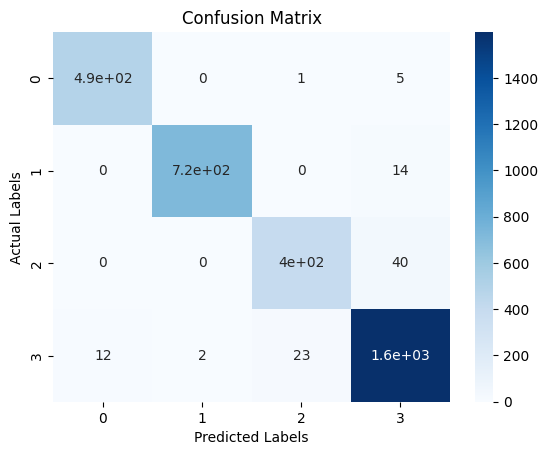

In [13]:
streamline_train_and_test(Autoencoder, tag="lstm_run_5_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0363, Val Loss: 0.0392
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0280, Val Loss: 0.0248
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0158, Val Loss: 0.0165
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0120, Val Loss: 0.0139
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0164, Val Loss: 0.0136
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0128, Val Loss: 0.0113
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0118, Val Loss: 0.0106
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0118, Val Loss: 0.0107
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0108, Val Loss: 0.0095
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0114, Val Loss: 0.0093
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0108, Val Loss: 0.0098
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0112, Val Loss: 0.0085
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0099, Val Loss: 0.0086
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0109, Val Loss: 0.0078
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0096, Val Loss: 0.0080
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0091, Val Loss: 0.0077
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0092, Val Loss: 0.0073
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0064, Val Loss: 0.0072
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0095, Val Loss: 0.0077
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0088, Val Loss: 0.0075
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0071, Val Loss: 0.0069
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0091, Val Loss: 0.0067
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0073, Val Loss: 0.0061
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0080, Val Loss: 0.0064
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0096, Val Loss: 0.0067
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0076, Val Loss: 0.0061
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0065, Val Loss: 0.0067
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0068, Val Loss: 0.0063
Early Stopping...


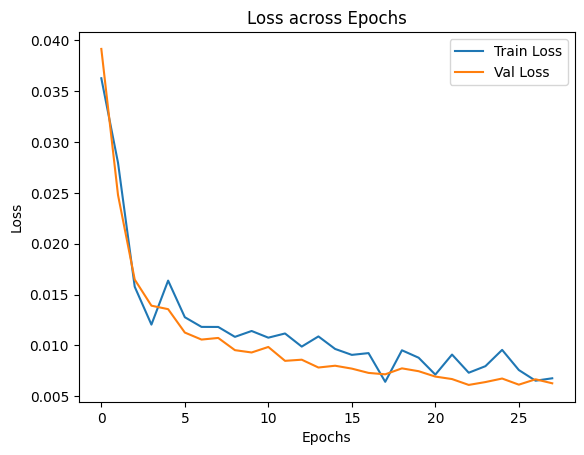

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9451640759930915


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 95.71%


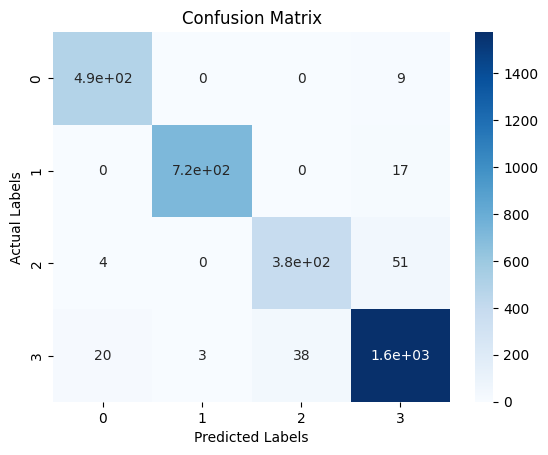

In [14]:
streamline_train_and_test(Autoencoder, tag="lstm_run_6_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0342, Val Loss: 0.0384
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0226, Val Loss: 0.0210
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0174, Val Loss: 0.0172
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0182, Val Loss: 0.0148
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0175, Val Loss: 0.0139
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0156, Val Loss: 0.0126
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0148, Val Loss: 0.0118
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0128, Val Loss: 0.0122
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0112, Val Loss: 0.0111
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0130, Val Loss: 0.0098
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0134, Val Loss: 0.0101
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0127, Val Loss: 0.0097
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0138, Val Loss: 0.0090
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0117, Val Loss: 0.0094
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0111, Val Loss: 0.0091
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0089, Val Loss: 0.0081
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0078, Val Loss: 0.0079
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0081, Val Loss: 0.0082
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0107, Val Loss: 0.0074
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0089, Val Loss: 0.0074
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0062, Val Loss: 0.0072
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0125, Val Loss: 0.0074
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0104, Val Loss: 0.0072
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0086, Val Loss: 0.0071
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0057, Val Loss: 0.0070
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0114, Val Loss: 0.0066
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0085, Val Loss: 0.0073
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0077, Val Loss: 0.0069
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0066, Val Loss: 0.0063
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0073, Val Loss: 0.0082
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0067, Val Loss: 0.0063
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0076, Val Loss: 0.0063
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0064, Val Loss: 0.0061
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0067, Val Loss: 0.0063
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0065, Val Loss: 0.0061
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0070, Val Loss: 0.0060
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0104, Val Loss: 0.0066
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0068, Val Loss: 0.0057
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0054, Val Loss: 0.0057
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0066, Val Loss: 0.0057
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0057, Val Loss: 0.0059
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0046, Val Loss: 0.0055
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0062, Val Loss: 0.0056
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0099, Val Loss: 0.0057
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0065, Val Loss: 0.0056
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0081, Val Loss: 0.0056
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0063, Val Loss: 0.0056
Early Stopping...


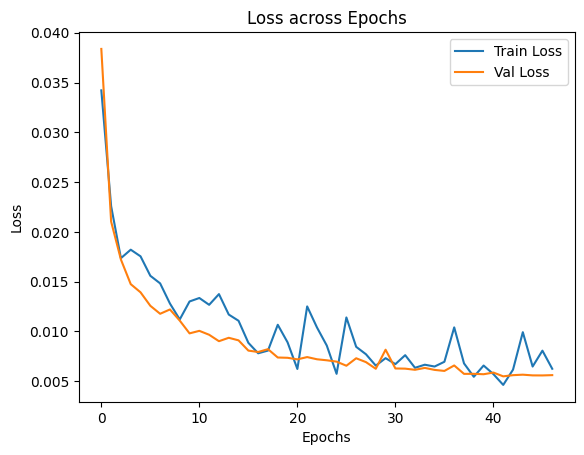

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9615716753022453


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.80%


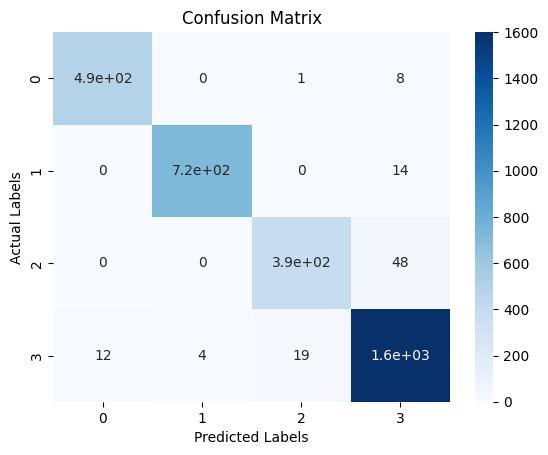

In [15]:
streamline_train_and_test(Autoencoder, tag="lstm_run_7_larm", early_stop=True, dropout_rate=0.3, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0678, Val Loss: 0.0762
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.1234, Val Loss: 0.0724
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.9576, Val Loss: 1.4047
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.7509, Val Loss: 0.5887
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 1.1550, Val Loss: 1.3489
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 1.1407, Val Loss: 1.1126
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.1965, Val Loss: 0.4360
Early Stopping...


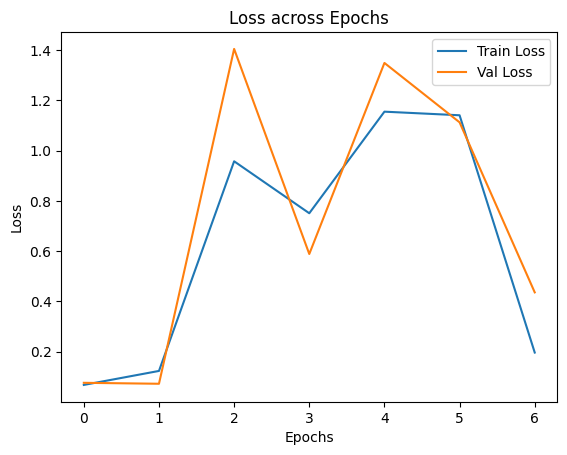

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.5099309153713298


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 49.43%


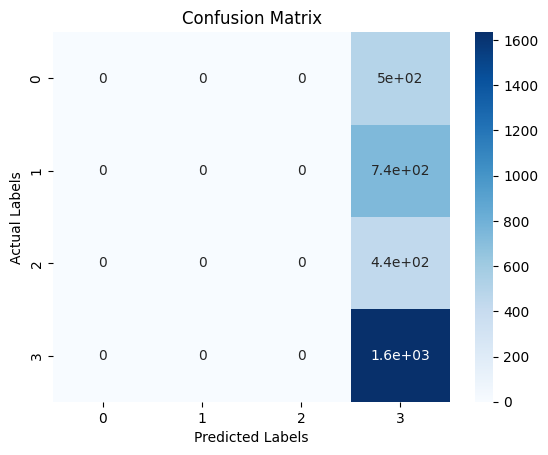

In [16]:
streamline_train_and_test(Autoencoder, tag="lstm_run_11_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.1)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0407, Val Loss: 0.0400
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0261, Val Loss: 0.0257
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0211, Val Loss: 0.0163
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0206, Val Loss: 0.0143
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0154, Val Loss: 0.0146
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0160, Val Loss: 0.0125
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0104, Val Loss: 0.0122
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0141, Val Loss: 0.0109
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0126, Val Loss: 0.0108
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0108, Val Loss: 0.0098
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0082, Val Loss: 0.0092
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0120, Val Loss: 0.0090
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0095, Val Loss: 0.0098
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0081, Val Loss: 0.0084
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0080, Val Loss: 0.0088
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0088, Val Loss: 0.0077
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0086, Val Loss: 0.0080
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0070, Val Loss: 0.0078
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0069, Val Loss: 0.0075
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0088, Val Loss: 0.0070
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0067, Val Loss: 0.0072
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0078, Val Loss: 0.0065
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0097, Val Loss: 0.0065
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0068, Val Loss: 0.0077
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0058, Val Loss: 0.0067
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0069, Val Loss: 0.0060
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0053, Val Loss: 0.0064
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0079, Val Loss: 0.0059
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0082, Val Loss: 0.0057
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0062, Val Loss: 0.0060
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0052, Val Loss: 0.0057
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0075, Val Loss: 0.0062
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0040, Val Loss: 0.0053
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0062, Val Loss: 0.0057
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0064, Val Loss: 0.0056
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0038, Val Loss: 0.0056
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0072, Val Loss: 0.0055
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0047, Val Loss: 0.0053
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0046, Val Loss: 0.0054
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0080, Val Loss: 0.0054
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0062, Val Loss: 0.0053
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0042, Val Loss: 0.0050
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0061, Val Loss: 0.0052
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0051, Val Loss: 0.0050
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0051, Val Loss: 0.0051
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0052, Val Loss: 0.0048
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0047, Val Loss: 0.0052
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0052, Val Loss: 0.0049
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0056, Val Loss: 0.0048
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0043, Val Loss: 0.0049


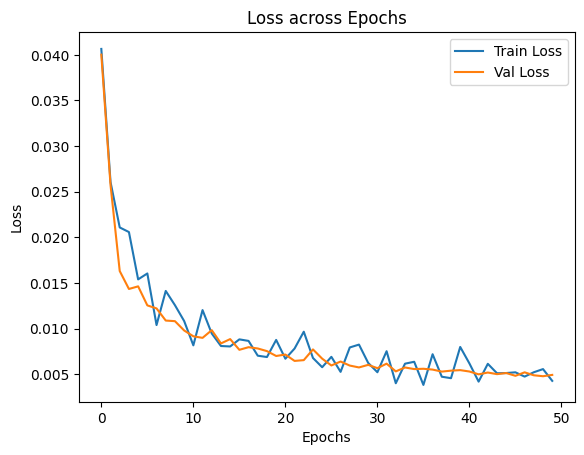

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9667530224525043


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 97.25%


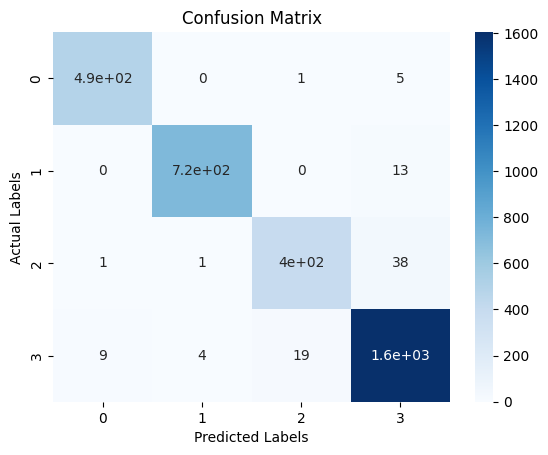

In [17]:
streamline_train_and_test(Autoencoder, tag="lstm_run_12_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.01)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0635, Val Loss: 0.0622
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0695, Val Loss: 0.0593
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0651, Val Loss: 0.0595
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0700, Val Loss: 0.0677
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0661, Val Loss: 0.0627
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0642, Val Loss: 0.0655
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0639, Val Loss: 0.0750
Early Stopping...


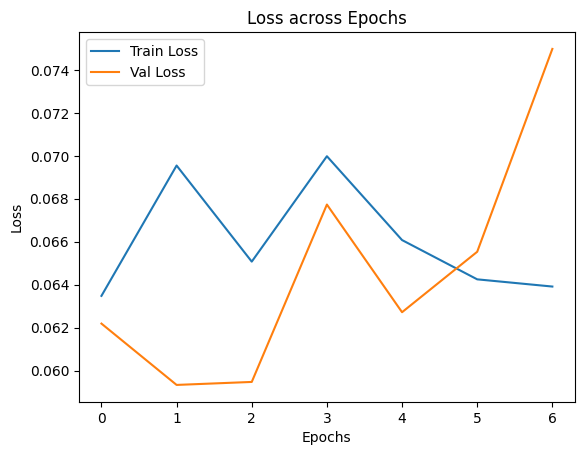

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.5047495682210709


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 49.43%


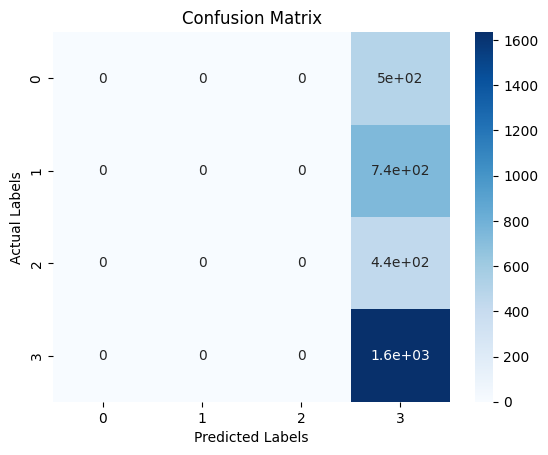

In [18]:
streamline_train_and_test(Autoencoder, tag="lstm_run_13_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.05)

In [19]:
# Bidirectional 2-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.2):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (encoded_x, _) = self.LSTM2(x)
        # Concatenate Forward + Backward Pass - (seq_len, batch, num_directions * hidden_size)  
        encoded_x = (encoded_x[0, :, :] + encoded_x[1, :, :])
        return encoded_x


class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.LSTM2 = nn.LSTM(input_size=2*hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.output = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x, (_, _) = self.LSTM2(x)
        x = self.output(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0287, Val Loss: 0.0327
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0152, Val Loss: 0.0130
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0138, Val Loss: 0.0111
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0077, Val Loss: 0.0089
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0075, Val Loss: 0.0076
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0057, Val Loss: 0.0070
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0054, Val Loss: 0.0065
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0053, Val Loss: 0.0062
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0088, Val Loss: 0.0058
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0055, Val Loss: 0.0052
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0057, Val Loss: 0.0050
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0034, Val Loss: 0.0046
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0038, Val Loss: 0.0046
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0036, Val Loss: 0.0041
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0028, Val Loss: 0.0041
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0022, Val Loss: 0.0039
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0039, Val Loss: 0.0039
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0041, Val Loss: 0.0036
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0018, Val Loss: 0.0034
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0034, Val Loss: 0.0037
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0023, Val Loss: 0.0033
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0030, Val Loss: 0.0032
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0025, Val Loss: 0.0032
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0018, Val Loss: 0.0031
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0028, Val Loss: 0.0029
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0034, Val Loss: 0.0031
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0026, Val Loss: 0.0028
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0022, Val Loss: 0.0027
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0026, Val Loss: 0.0027
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0015, Val Loss: 0.0028
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0016, Val Loss: 0.0024
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0029, Val Loss: 0.0025
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0017, Val Loss: 0.0023
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0022, Val Loss: 0.0025
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0016, Val Loss: 0.0025
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0019, Val Loss: 0.0024
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0017, Val Loss: 0.0023
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0017, Val Loss: 0.0024
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0014, Val Loss: 0.0022
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0018, Val Loss: 0.0022
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0021, Val Loss: 0.0025
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0015, Val Loss: 0.0022
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0023, Val Loss: 0.0024
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0011, Val Loss: 0.0022
Early Stopping...


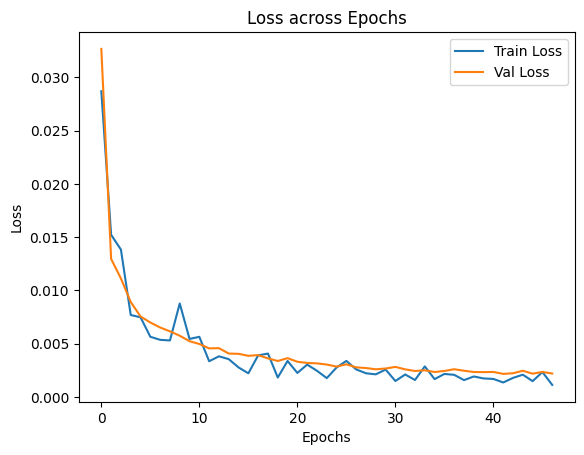

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9602763385146805


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.89%


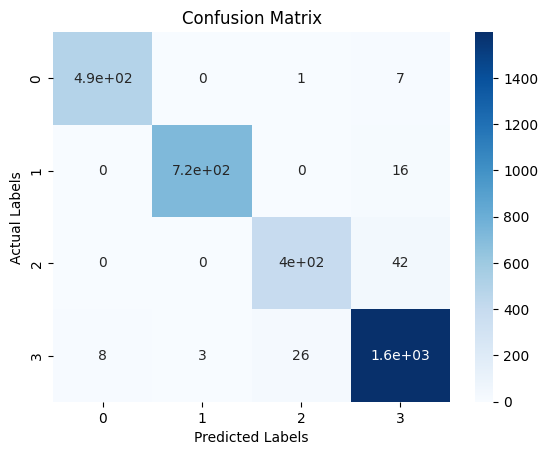

In [20]:
streamline_train_and_test(Autoencoder, tag="lstm_run_4_larm", early_stop=True, dropout_rate=0, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0330, Val Loss: 0.0274
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0156, Val Loss: 0.0135
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0114, Val Loss: 0.0104
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0062, Val Loss: 0.0082
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0095, Val Loss: 0.0073
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0046, Val Loss: 0.0069
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0066, Val Loss: 0.0062
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0063, Val Loss: 0.0058
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0055, Val Loss: 0.0054
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0053, Val Loss: 0.0053
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0050, Val Loss: 0.0049
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0039, Val Loss: 0.0054
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0043, Val Loss: 0.0047
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0036, Val Loss: 0.0046
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0043, Val Loss: 0.0042
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0037, Val Loss: 0.0040
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0040, Val Loss: 0.0039
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0036, Val Loss: 0.0037
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0044, Val Loss: 0.0039
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0023, Val Loss: 0.0035
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0047, Val Loss: 0.0035
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0037, Val Loss: 0.0035
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0038, Val Loss: 0.0034
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0037, Val Loss: 0.0031
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0039, Val Loss: 0.0032
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0031, Val Loss: 0.0031
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0026, Val Loss: 0.0031
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0021, Val Loss: 0.0029
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0030, Val Loss: 0.0029
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0046, Val Loss: 0.0030
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0025, Val Loss: 0.0028
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0019, Val Loss: 0.0030
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0033, Val Loss: 0.0028
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0028, Val Loss: 0.0027
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0027, Val Loss: 0.0028
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0026, Val Loss: 0.0026
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0024, Val Loss: 0.0026
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0022, Val Loss: 0.0026
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0021, Val Loss: 0.0026
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0025, Val Loss: 0.0026
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0019, Val Loss: 0.0026
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0019, Val Loss: 0.0025
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0020, Val Loss: 0.0025
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0021, Val Loss: 0.0025
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0022, Val Loss: 0.0025
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0019, Val Loss: 0.0025
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0026, Val Loss: 0.0024
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0023, Val Loss: 0.0025
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0018, Val Loss: 0.0024


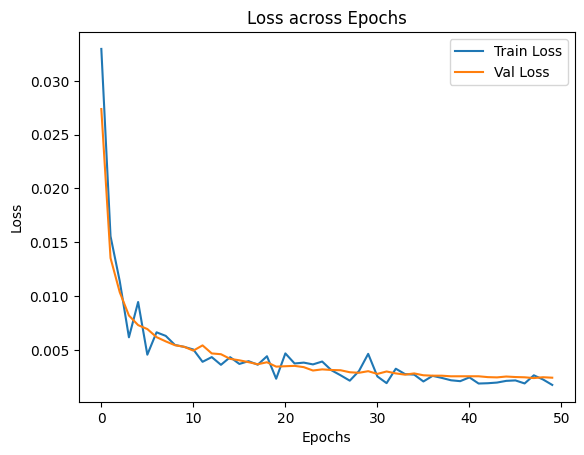

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9684801381692574


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.92%


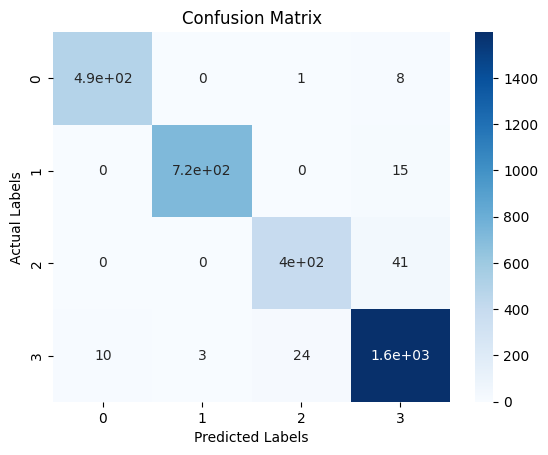

In [21]:
streamline_train_and_test(Autoencoder, tag="lstm_run_8_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0352, Val Loss: 0.0365
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0179, Val Loss: 0.0133
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0141, Val Loss: 0.0100
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0101, Val Loss: 0.0087
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0093, Val Loss: 0.0073
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0075, Val Loss: 0.0072
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0074, Val Loss: 0.0064
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0054, Val Loss: 0.0060
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0040, Val Loss: 0.0055
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0057, Val Loss: 0.0057
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0048, Val Loss: 0.0051
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0061, Val Loss: 0.0053
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0049, Val Loss: 0.0048
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0053, Val Loss: 0.0048
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0032, Val Loss: 0.0044
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0039, Val Loss: 0.0043
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0027, Val Loss: 0.0040
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0035, Val Loss: 0.0039
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0037, Val Loss: 0.0039
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0044, Val Loss: 0.0038
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0022, Val Loss: 0.0034
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0055, Val Loss: 0.0034
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0045, Val Loss: 0.0032
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0035, Val Loss: 0.0032
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0022, Val Loss: 0.0032
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0027, Val Loss: 0.0032
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0036, Val Loss: 0.0031
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0023, Val Loss: 0.0030
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0026, Val Loss: 0.0031
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0033, Val Loss: 0.0031
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0029, Val Loss: 0.0031
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0022, Val Loss: 0.0029
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0019, Val Loss: 0.0027
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0017, Val Loss: 0.0028
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0019, Val Loss: 0.0027
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0025, Val Loss: 0.0028
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0022, Val Loss: 0.0026
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0027, Val Loss: 0.0026
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0027, Val Loss: 0.0027
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0023, Val Loss: 0.0026
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0018, Val Loss: 0.0025
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0032, Val Loss: 0.0025
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0022, Val Loss: 0.0026
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0025, Val Loss: 0.0027
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0026, Val Loss: 0.0024
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0026, Val Loss: 0.0025
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0029, Val Loss: 0.0025
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0022, Val Loss: 0.0024
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0022, Val Loss: 0.0024
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0030, Val Loss: 0.0023


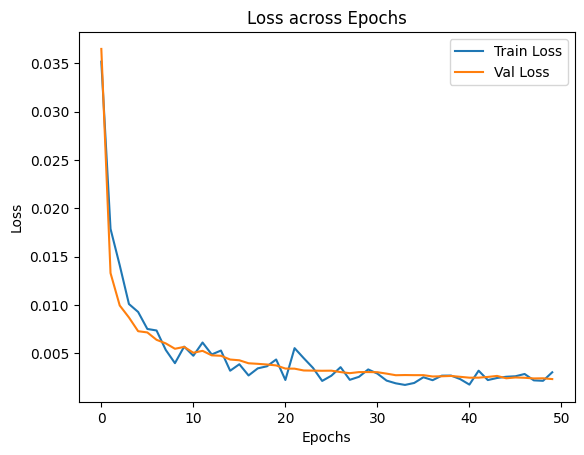

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9546632124352331


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.67%


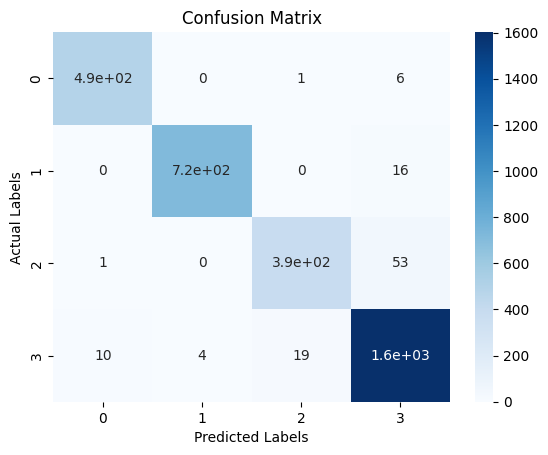

In [22]:
streamline_train_and_test(Autoencoder, tag="lstm_run_9_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0432, Val Loss: 0.0366
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0167, Val Loss: 0.0143
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0115, Val Loss: 0.0104
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0092, Val Loss: 0.0096
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0072, Val Loss: 0.0082
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0066, Val Loss: 0.0070
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0064, Val Loss: 0.0071
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0052, Val Loss: 0.0060
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0058, Val Loss: 0.0059
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0067, Val Loss: 0.0057
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0068, Val Loss: 0.0060
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0046, Val Loss: 0.0055
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0037, Val Loss: 0.0050
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0032, Val Loss: 0.0054
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0054, Val Loss: 0.0045
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0052, Val Loss: 0.0045
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0049, Val Loss: 0.0041
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0039, Val Loss: 0.0042
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0030, Val Loss: 0.0040
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0051, Val Loss: 0.0039
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0040, Val Loss: 0.0037
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0046, Val Loss: 0.0039
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0023, Val Loss: 0.0035
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0046, Val Loss: 0.0035
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0033, Val Loss: 0.0036
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0041, Val Loss: 0.0033
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0045, Val Loss: 0.0034
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0040, Val Loss: 0.0032
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0034, Val Loss: 0.0032
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0031, Val Loss: 0.0033
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0029, Val Loss: 0.0030
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0035, Val Loss: 0.0030
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0029, Val Loss: 0.0029
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0030, Val Loss: 0.0031
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0031, Val Loss: 0.0031
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0034, Val Loss: 0.0029
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0029, Val Loss: 0.0028
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0024, Val Loss: 0.0027
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0030, Val Loss: 0.0028
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0032, Val Loss: 0.0027
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0031, Val Loss: 0.0027
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0029, Val Loss: 0.0027
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0029, Val Loss: 0.0029
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0026, Val Loss: 0.0026
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0024, Val Loss: 0.0026
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0023, Val Loss: 0.0025
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0020, Val Loss: 0.0025
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0022, Val Loss: 0.0026
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0026, Val Loss: 0.0025
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0026, Val Loss: 0.0024


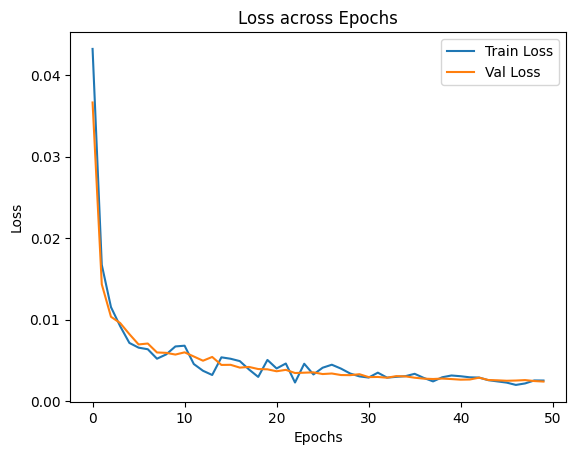

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9568221070811744


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.43%


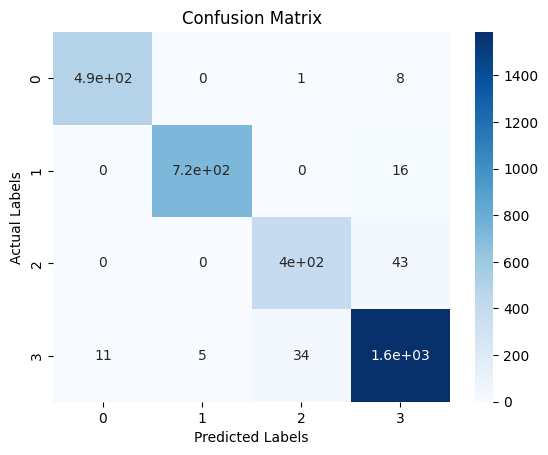

In [23]:
streamline_train_and_test(Autoencoder, tag="lstm_run_10_larm", early_stop=True, dropout_rate=0.3, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0673, Val Loss: 0.0757
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0782, Val Loss: 0.1119
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.2302, Val Loss: 0.2339
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.4059, Val Loss: 0.4571
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 1.6509, Val Loss: 1.6722
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.6078, Val Loss: 0.8227
Early Stopping...


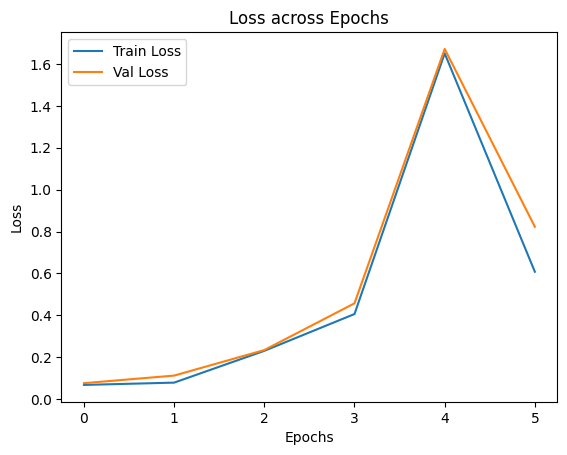

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.5


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 49.43%


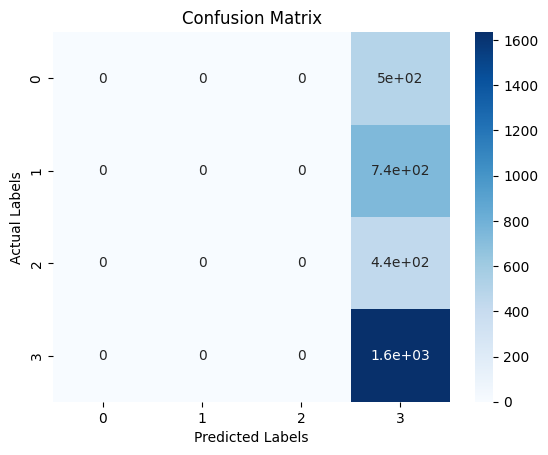

In [24]:
streamline_train_and_test(Autoencoder, tag="lstm_run_14_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.1)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0620, Val Loss: 0.0805
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0609, Val Loss: 0.0704
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0690, Val Loss: 0.0690
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0589, Val Loss: 0.0686
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0518, Val Loss: 0.0600
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0694, Val Loss: 0.0772
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0841, Val Loss: 0.0641
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0509, Val Loss: 0.0638
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0753, Val Loss: 0.0628
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0643, Val Loss: 0.0637
Early Stopping...


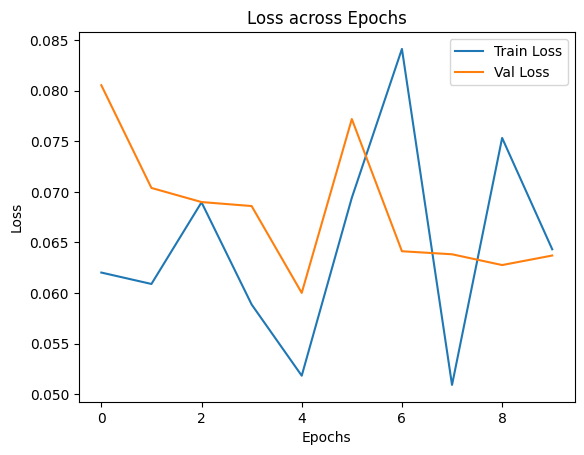

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.5107944732297064


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 49.43%


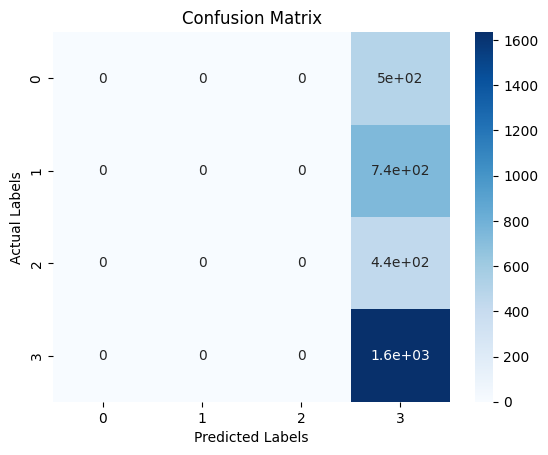

In [25]:
streamline_train_and_test(Autoencoder, tag="lstm_run_15_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.01)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (LSTM2): LSTM(720, 360, batch_first=True, bidirectional=True)
    (output): Linear(in_features=720, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0778, Val Loss: 0.1034
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.1474, Val Loss: 0.2126
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.1304, Val Loss: 0.1423
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.2482, Val Loss: 0.1757
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.1419, Val Loss: 0.1551
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.2381, Val Loss: 0.2081
Early Stopping...


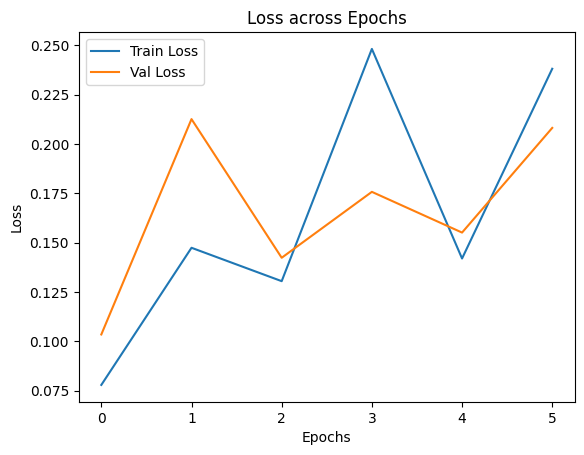

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.4991364421416235


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 49.43%


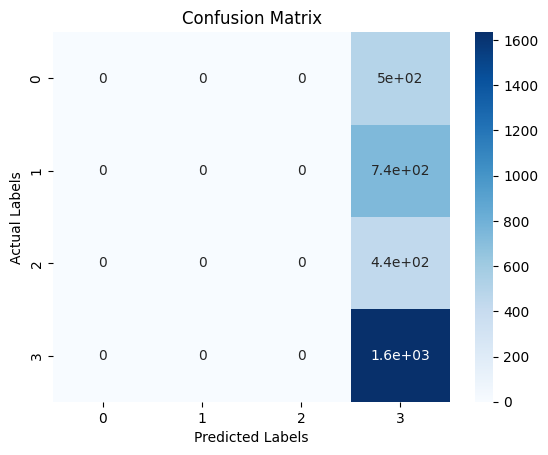

In [26]:
streamline_train_and_test(Autoencoder, tag="lstm_run_16_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=0.05)

In [27]:
# Bidirectional 1-Layer LSTM
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super(Encoder, self).__init__()
        self.LSTM1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_size = hidden_size

    def forward(self, x):
        x, (encoded_x, _) = self.LSTM1(x)
        x = self.dropout(encoded_x)
        return x[-1,:,:]

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_rate):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output1 = nn.Linear(hidden_size*2, hidden_size)
        self.output2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, 60, 1)
        x, (_, _) = self.LSTM1(x)
        x = self.dropout(x)
        x = self.output1(x)
        x = self.output2(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, in_out_size, hidden_size, dropout_rate):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(in_out_size, hidden_size, dropout_rate).to(device)
        self.decoder = Decoder(hidden_size, in_out_size, dropout_rate).to(device)

        self.loss = nn.MSELoss()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (output1): Linear(in_features=720, out_features=360, bias=True)
    (output2): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0452, Val Loss: 0.0400
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0187, Val Loss: 0.0204
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0124, Val Loss: 0.0154
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0137, Val Loss: 0.0142
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0138, Val Loss: 0.0123
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0126, Val Loss: 0.0110
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0098, Val Loss: 0.0108
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0130, Val Loss: 0.0099
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0109, Val Loss: 0.0099
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0090, Val Loss: 0.0095
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0077, Val Loss: 0.0093
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0105, Val Loss: 0.0081
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0087, Val Loss: 0.0084
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0064, Val Loss: 0.0077
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0060, Val Loss: 0.0081
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0063, Val Loss: 0.0075
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0072, Val Loss: 0.0070
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0058, Val Loss: 0.0066
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0056, Val Loss: 0.0067
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0062, Val Loss: 0.0064
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0085, Val Loss: 0.0069
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0089, Val Loss: 0.0063
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0094, Val Loss: 0.0060
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0047, Val Loss: 0.0060
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0054, Val Loss: 0.0061
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0050, Val Loss: 0.0057
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0039, Val Loss: 0.0055
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0067, Val Loss: 0.0054
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0050, Val Loss: 0.0055
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0059, Val Loss: 0.0053
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0062, Val Loss: 0.0053
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0038, Val Loss: 0.0052
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0076, Val Loss: 0.0055
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0057, Val Loss: 0.0051
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0046, Val Loss: 0.0050
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0057, Val Loss: 0.0050
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0062, Val Loss: 0.0048
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0058, Val Loss: 0.0048
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0051, Val Loss: 0.0048
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0057, Val Loss: 0.0051
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0050, Val Loss: 0.0048
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0063, Val Loss: 0.0048
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0053, Val Loss: 0.0048
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0043, Val Loss: 0.0044
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0045, Val Loss: 0.0047
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0037, Val Loss: 0.0049
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0073, Val Loss: 0.0047
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0049, Val Loss: 0.0045
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0037, Val Loss: 0.0043
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0054, Val Loss: 0.0045


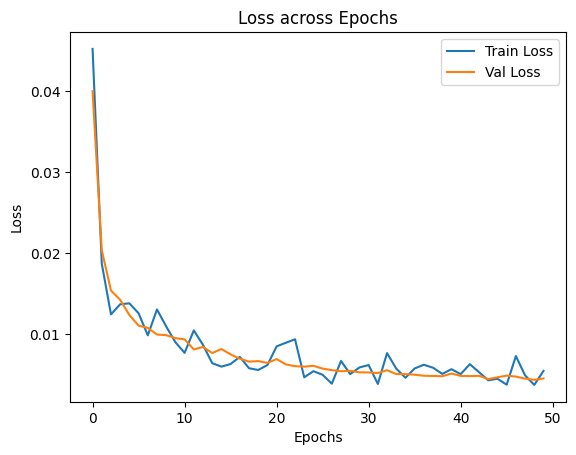

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9550949913644214


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.67%


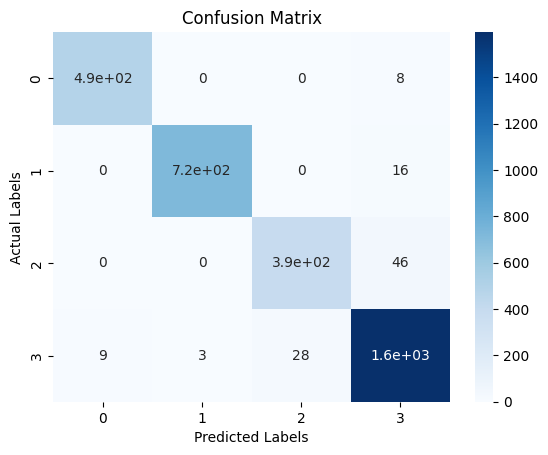

In [28]:
streamline_train_and_test(Autoencoder, tag="lstm_run_17_larm", early_stop=True, dropout_rate=0.1, num_epochs=50, lr_rate=1e-3)

Autoencoder(
  (encoder): Encoder(
    (LSTM1): LSTM(9, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(360, 360, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (output1): Linear(in_features=720, out_features=360, bias=True)
    (output2): Linear(in_features=360, out_features=9, bias=True)
  )
  (loss): MSELoss()
)
Starting Epoch 1...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1/50]
Training Loss: 0.0337, Val Loss: 0.0387
Starting Epoch 2...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2/50]
Training Loss: 0.0212, Val Loss: 0.0281
Starting Epoch 3...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3/50]
Training Loss: 0.0198, Val Loss: 0.0202
Starting Epoch 4...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4/50]
Training Loss: 0.0144, Val Loss: 0.0159
Starting Epoch 5...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5/50]
Training Loss: 0.0153, Val Loss: 0.0141
Starting Epoch 6...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6/50]
Training Loss: 0.0151, Val Loss: 0.0128
Starting Epoch 7...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7/50]
Training Loss: 0.0111, Val Loss: 0.0117
Starting Epoch 8...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8/50]
Training Loss: 0.0107, Val Loss: 0.0112
Starting Epoch 9...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9/50]
Training Loss: 0.0164, Val Loss: 0.0115
Starting Epoch 10...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10/50]
Training Loss: 0.0126, Val Loss: 0.0098
Starting Epoch 11...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11/50]
Training Loss: 0.0105, Val Loss: 0.0100
Starting Epoch 12...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12/50]
Training Loss: 0.0107, Val Loss: 0.0096
Starting Epoch 13...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13/50]
Training Loss: 0.0088, Val Loss: 0.0091
Starting Epoch 14...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14/50]
Training Loss: 0.0091, Val Loss: 0.0085
Starting Epoch 15...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15/50]
Training Loss: 0.0098, Val Loss: 0.0084
Starting Epoch 16...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [16/50]
Training Loss: 0.0119, Val Loss: 0.0082
Starting Epoch 17...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [17/50]
Training Loss: 0.0087, Val Loss: 0.0079
Starting Epoch 18...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [18/50]
Training Loss: 0.0090, Val Loss: 0.0071
Starting Epoch 19...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [19/50]
Training Loss: 0.0091, Val Loss: 0.0078
Starting Epoch 20...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [20/50]
Training Loss: 0.0096, Val Loss: 0.0077
Starting Epoch 21...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [21/50]
Training Loss: 0.0079, Val Loss: 0.0067
Starting Epoch 22...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [22/50]
Training Loss: 0.0091, Val Loss: 0.0071
Starting Epoch 23...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [23/50]
Training Loss: 0.0062, Val Loss: 0.0068
Starting Epoch 24...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [24/50]
Training Loss: 0.0062, Val Loss: 0.0067
Starting Epoch 25...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [25/50]
Training Loss: 0.0073, Val Loss: 0.0063
Starting Epoch 26...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [26/50]
Training Loss: 0.0082, Val Loss: 0.0066
Starting Epoch 27...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [27/50]
Training Loss: 0.0071, Val Loss: 0.0061
Starting Epoch 28...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [28/50]
Training Loss: 0.0064, Val Loss: 0.0060
Starting Epoch 29...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [29/50]
Training Loss: 0.0080, Val Loss: 0.0059
Starting Epoch 30...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [30/50]
Training Loss: 0.0051, Val Loss: 0.0059
Starting Epoch 31...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [31/50]
Training Loss: 0.0065, Val Loss: 0.0059
Starting Epoch 32...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [32/50]
Training Loss: 0.0073, Val Loss: 0.0057
Starting Epoch 33...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [33/50]
Training Loss: 0.0070, Val Loss: 0.0059
Starting Epoch 34...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [34/50]
Training Loss: 0.0070, Val Loss: 0.0058
Starting Epoch 35...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [35/50]
Training Loss: 0.0068, Val Loss: 0.0057
Starting Epoch 36...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [36/50]
Training Loss: 0.0058, Val Loss: 0.0055
Starting Epoch 37...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [37/50]
Training Loss: 0.0059, Val Loss: 0.0055
Starting Epoch 38...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [38/50]
Training Loss: 0.0063, Val Loss: 0.0053
Starting Epoch 39...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [39/50]
Training Loss: 0.0071, Val Loss: 0.0054
Starting Epoch 40...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [40/50]
Training Loss: 0.0068, Val Loss: 0.0054
Starting Epoch 41...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [41/50]
Training Loss: 0.0066, Val Loss: 0.0052
Starting Epoch 42...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [42/50]
Training Loss: 0.0067, Val Loss: 0.0052
Starting Epoch 43...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [43/50]
Training Loss: 0.0060, Val Loss: 0.0053
Starting Epoch 44...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [44/50]
Training Loss: 0.0069, Val Loss: 0.0051
Starting Epoch 45...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [45/50]
Training Loss: 0.0068, Val Loss: 0.0051
Starting Epoch 46...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [46/50]
Training Loss: 0.0044, Val Loss: 0.0049
Starting Epoch 47...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [47/50]
Training Loss: 0.0057, Val Loss: 0.0050
Starting Epoch 48...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [48/50]
Training Loss: 0.0044, Val Loss: 0.0049
Starting Epoch 49...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [49/50]
Training Loss: 0.0055, Val Loss: 0.0050
Starting Epoch 50...


  0%|          | 0/724 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [50/50]
Training Loss: 0.0077, Val Loss: 0.0049


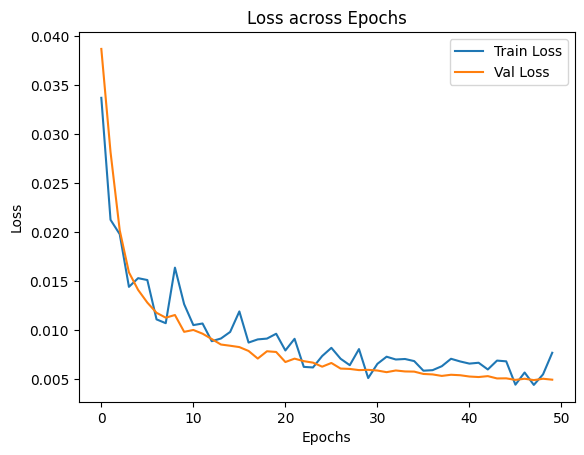

Loading Encoder Model...
Encoding Data...


  0%|          | 0/724 [00:00<?, ?it/s]

encoded_data.shape=torch.Size([11578, 360])
labels.shape=torch.Size([11578, 1])
Training SVM Classifier...
Accuracy: 0.9563903281519862


  0%|          | 0/207 [00:00<?, ?it/s]

test_encoded_data.shape=torch.Size([3308, 360])
test_labels.shape=torch.Size([3308, 1])
test_predictions.shape=(3308,)
Accuracy: 96.95%


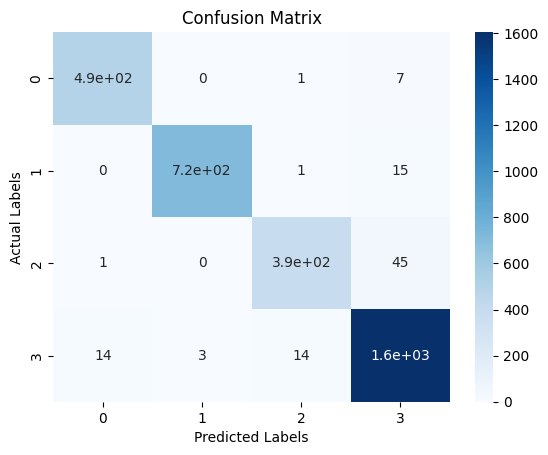

In [29]:
streamline_train_and_test(Autoencoder, tag="lstm_run_18_larm", early_stop=True, dropout_rate=0.2, num_epochs=50, lr_rate=1e-3)